# Assignment 1 by Lennart Tuijnder (VUB)

All the exploratory work and fiddling around can be found back on: https://github.com/ltuijnder/BioInformatics_Assignment1 
This notebook summarises all the important analysis and describes the code and my choices

In [3]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Part 1: GOR algorithm

Let's first start with the import of the data and along the way introduce concepts on how I do the analysis.

## Importing the data: 

### Create a dataframe
So we have been given two input data files: `dssp_info.txt`, `stride_info.txt` where each row is an amino acid entry of a given protein. 

The data file imported via the module `pandas` using the function `read_csv`, we now have hold of a `pandas.dataframe` object which is basically a fancy excel table. We can tell the dataframe that we want to group our data on the column on the proteins such that we can easily just loop over protein per protein. 

We should also group the data by `PDB_chain_code` since our data sets contains instance of proteins  that are present multiple times (4 times "1n7s", and 2 times "1wmh") but have a different `chain_code` attachted to them. One protein can fold in different ways and hence form different secundary strucutres (SS), so to our analysis with the GOR we treat them as different proteins. 

Now that we have grouped our dataframe we can loop over each individual protein and acces its specific information.

### Converting residues to numbers

Next, we turn our attention to the residues of the proteins. These will be converted to numbers since we will want to store information in matrixes whose row/column are in function of the residue. It is then easier to map every residue to a specific column/row number which makes working with the data Matrix easier. 

The same needs to be done for the SS where we also converge the SS "Other" to the same intiger value as "Coil".

In [4]:
# Define conversion dictionaries
aminoToNumber = {"ALA":0, "ARG":1, "ASN":2, "ASP":3, "CYS":4, "GLN":5, "GLU":6, "GLY":7, "HIS":8, "ILE":9, "LEU":10, "LYS":11, "MET":12, "PHE":13, "PRO":14, "SER":15, "THR":16, "TRP":17, "TYR":18, "VAL":19}
shortAminoToNumber = {"A":0, "R":1, "N":2, "D":3, "C":4, "Q":5, "E":6, "G":7, "H":8, "I":9, "L":10, "K":11, "M":12, "F":13, "P":14, "S":15, "T":16, "W":17, "Y":18, "V":19}
SStoNumber = {"Helix":0, "Beta":1, "Coil":2, "Other":2}
shortSStoNumber = {"H":0, "E":1, "C":2}
numberToStringSS = {0:"H", 1:"E", 2:"C"}

The converges happens within the `pandas` framework with the `map` function. The great thing is that entries that were not defined in the dictionary are automatically mapped to `NaN`. We can now easily flag residues that are not one of the standard 20 aminoacids to `-1`.  

We let -1 represent "invalid" entry. We keep those -1's since our GOR algorithm needs to run over the sequence where the position between residues is very important! Hence, rather then removing entries we flag them with -1 such that we tell GOR to ignore these, this way we preserve the distance between valid residues.

### Dealing with the skips

Last thing that we need to deal with in our input data is that sometimes full sections are missing in the proteins. For example, in protein "1j3a" the `PDB_seq_code` skips from 53 to 67. To really make sure that these skips correspond with real physical distance between the aminoacids of the protein I had a look at the PDB files. And indeed after looking around I found the protein "1j3a":

> REMARK 465                                                                      
REMARK 465 MISSING RESIDUES                                                     
REMARK 465 THE FOLLOWING RESIDUES WERE NOT LOCATED IN THE                       
REMARK 465 EXPERIMENT. (M=MODEL NUMBER; RES=RESIDUE NAME; C=CHAIN               
REMARK 465 IDENTIFIER; SSSEQ=SEQUENCE NUMBER; I=INSERTION CODE.)                
REMARK 465                                                                      
REMARK 465   M RES C SSSEQI                                                     
REMARK 465     GLY A    54                                                      
REMARK 465     LEU A    55                                                      
REMARK 465     ARG A    56                                                      
REMARK 465     THR A    57                                                      
REMARK 465     LEU A    58                                                      
REMARK 465     THR A    59                                                      
REMARK 465     ASN A    60                                                      
REMARK 465     PRO A    61                                                      
REMARK 465     ARG A    62                                                      
REMARK 465     ARG A    63                                                      
REMARK 465     GLY A    64                                                      
REMARK 465     PRO A    65                                                      
REMARK 465     PHE A    66 

Thus the amino acids are know, but the location could not be determined hence on those location you can then also not infer the SS. And thus the information of the SS is simply missing over there. We can assume that this is the case for all skips that happen.

But in the GOR III algorithm it is very important that relative distance between residues is correct. To solve this we are going to add additional dummy entries flagged with "-1" for both the residue sequence and the SS sequence. Flag them with "-1" such that the GOR algorithm know to ignore these dummy entries.

It is important that we add these, since if for instance a skip of 1 happens well then the amino acid on the left of the skip needs to know that the amino acid on the right is not its neighbour (m=1) but its next to neirest neighbour (m=2).

The number of dummy entries that we add is equal to the amount of skips that happend, except if the skips exceed 8 then just add 8. We only add maximum 8 because the window with which the GOR 3 algorithm looks around from a position $j$ is only maximumly 8 to one side. And since the GOR algorithm is going to skip the "-1" entries at its centre position $j$, we then do not have to fear overlap between two distant regions. 

### The function "createDataset"

All that what has been covered above is done by one function named `createDataset`. Which only takes as argument which input data file it should consider (either "dssp" or "stride"). 

It then returns the data as dictionary with the keys the protein name who are structured as follows: `"PDB_code"+"_"+"PDB_chain_code"`, such that each key always unique. 

At each key we store tuple that stores a numpy array of the residue sequence (in intigers) and a numpy array of the SS (also intigers).

From this dictionary we will do the rest of our analysis.

#### Small note:
One last small note. I have only changed one minor detail in the input data. Namely the sequence numbers of the first three residues of protein "1fsg" in the stride dataset where all "0". This is ofcourse not possible and after a quick check on PDB to verify I changed it to [-2,-1,0] manually in the `stride_info.txt` file.

In [5]:
def createDataset(dataSet = "dssp"):
    # MODIFIED sequence 1fsg in stride data set!
    df = pd.read_csv("inputData/"+dataSet+"_info.txt", sep="\t", header=None, names=["PDB_code", "PDB_chain_code", "PDB_seq_code", "residue_name", "SS"])
    df['residue_name'] = pd.to_numeric( df['residue_name'].map(aminoToNumber).fillna(-1), downcast='signed')# Fill non matching (aka the not standard amino acids) = -1
    df["SS"] = pd.to_numeric( df["SS"].map(SStoNumber), downcast="signed")
    
    grouped = df.groupby(["PDB_code","PDB_chain_code"], sort=False)

    proteinDict = {}
    for (proteinCode, chainCode), proteinData in grouped:
        rPosition = proteinData["PDB_seq_code"].values
        skipped = np.diff(rPosition)-1
        hasSkipped = np.sum(skipped)!=0
        
        sequence = proteinData["residue_name"].values
        SS = proteinData["SS"].values
        
        if hasSkipped:
            indexesSkipped = np.where(skipped!=0)[0]
            SS = proteinData["SS"].values
        
            # Add -1's on the places where it skipped.
            # Add these seperately add these first seperatatly in a tuple, to not mess up the counting.
            newSequence = () 
            newSS = ()
            
            previousIndex = 0
            for index in indexesSkipped:
                newSequence += (sequence[previousIndex:(index+1)],) # Add the section between the skipped area's
                newSS += (SS[previousIndex:(index+1)],) # Add +1 since the coordinat where the skips happens is still part of the previous section before the skip.
                numberSkipped = skipped[index]
                
                newSequence += (-np.ones(numberSkipped if numberSkipped<8 else 8) ,) # Add the -1's
                newSS += (-np.ones(numberSkipped if numberSkipped<8 else 8) ,)
                previousIndex = index+1
                
            newSequence += (sequence[previousIndex:],)
            newSS += (SS[previousIndex:],)
            
            sequence = np.concatenate(newSequence)
            SS = np.concatenate(newSS)
            
        proteinDict[proteinCode+"_"+chainCode] = (sequence, SS)
    
    return proteinDict

## The GOR algorithm and the frequency table:

I will now discuss on how I implemented the GOR algorithm and the frequency table

The GOR algorithm is based on information theory and there for uses probability distributions. With GOR 3 we evaluate the probability that we would have a certain residue $r_{j+m}$ with "$m\in(-8,...,+8)$" steps away from a position $j$ who has SS $s_j$ and residue $r_j$. 

These distribution will be approximated with freqencies or counts (in this text frequencies and counts are interchangeable). For the GOR 3 algorithm we need to be able to count the following frequency configuration: $$ F_{s_j,m,r_{jm},r}$$
which represents the count that at position $j$ there was a SS $s_j$ with residue $r_j$ and at position $m$ a residue $r_{jm}$. All probabilities distributions that need to be approximated can be stored within this giant four dimensional matrix that has the following size: $$ (F_{s_j,m,r_{jm},r}).shape=(3,17,20,20)$$
The first 3 is because the SS at position $j$, it can be Helix(H), Sheet(E) or Coil (C). There are 17 different m values, 8 to the left side of $j$ (the negative $m$ values), 8 to the right side (the positive $m$ values) and $m=0$ which results in 17 configurations. And lastly we have the 20 aminoacids, the one at axis=2 will represent the amino acid on position $j+m$ and the last axis = 3 will represent the residue at position $j$ 

And thus as explained above I will also store the central positions $m=0$ in this frequency Table/matrix. This means we are not super efficient with our memory since at $m=0$, $r_j=r_{j+m}$ and hence only the diagonal will be used. In the end I have decided to store everything in this one matrix and not bother with handeling a second one. 

### Constructing the full frequency matrix of the data set.

To construct the full frequency matrix of the whole dataset we simply need to compute the frequency table of each protein seperatly and sum them up. For this I have constructed the function `freqTableOfProtein`, that returns this frequency table.

To compute the frequency table. We construct a sliding window that loops over all positions on the sequences centered around position $j$ and then loop over all $m\in(-8,...,8)$, and increment the frequency table at $s_j$,$m$,$r_{j+m}$,$r_j$. If $r_{jm}$ is -1, we skip it since it does not provide us any information. If at our position $r_j$ we skip that window position completly.

The only problem residues at the sides, since we cannot centre a window at position 0. To solve this add eight "-1" to both sides of the sequence (for both the residues and SS sequence). Now we can simply add the window at position 0 and because on the left it is all -1 the window will ignore that side.

It is ok to use windows where the information is only partially, Each position $m$ says something individually about $s_j$ and so it does not matter if there are some gaps.

---
Finally the function also returns the total count of each SS and the total count of each SS per residue. This information can directly be extracted from the diagonal of the frequency matrix at $m=0$. 

This is done for convenience since we later on need to compute for the self information:
$$ \log( \frac{F_{n-S}}{F_{S}} ) $$
and for the pair information:
$$ \log(\frac{F_{n-S,R_j}}{F_{S,R_j}}) $$
So it is handy to have those special frequencies already seperated from the big frequency matrix.

In [6]:
def freqTableOfProtein(protSequence,SS):
    """
    Input:
        - protSequence : 1D-numpy array, Represents the proteins sequence, where the aminoacids are labeled as integers from 0 to 19
        - SS : 1D-numpy array holding the know secundary structure of the 
    Output:
    - freq : 4D-numpy array shape = (3,17,20,20) representing the frequency count of the protein sequence.
            - axis0 = Secundary structure
            - axis1 = relative position m from the window center positioned at j in the protein sequence
            - axis2 = amino Acid at the position m. = R_{j+m}
            - axis3 = amino Acid at the centre. = R_j
    - countSS : returns the total counts of each type of secundary structure in the sequence
    - coutSSperR: return the count of each type of secundary structure per amino acid.
    """
    freqTable = np.zeros(shape=(3,17,20,20))
    
    # Pad the sequence with 8 -1's before and after such that we can easily perform move a window around. 
    paddedSequence = np.concatenate((-np.ones(8),protSequence,-np.ones(8))).astype(int)
    paddedSS = np.concatenate((-np.ones(8),SS,-np.ones(8))).astype(int)
    
    seqLen = len(protSequence)
    
    
    #Fill freqTable
    for j, (r_j, S_j) in enumerate(zip(paddedSequence,paddedSS)):      
        if (j-8) > seqLen: # We have reached the end.
            break    
        if r_j<0: # We skip over invalid entries. (These are the padded edges and invalid entries)
            continue
        for m in np.arange(-8,9):#  m=[-8,...,8]
            r_jm = paddedSequence[j+m]
            if r_jm<0:
                continue
            freqTable[S_j,m+8,r_jm,r_j]+=1
            
    middleTable = freqTable[:,8] # take all the freq counts on m=0. 
    countSSperR = np.copy(middleTable.diagonal(axis1=-1,axis2=-2)) # Extract the diagonal
    countSS = np.copy(np.sum(countSSperR,axis=-1))
    
    return freqTable, countSS, countSSperR

### Predicting the SS via GOR 3

Now it is time to implement the GOR alogirthm and start predicting the SS of sequences.

In much the same fashion that we have constructed the frequency table, we again loop over the sequence with a running window centered at position $j$ and evaluate in a region $m\in(-8,...,8)$ around it. Thus one again we add eight -1's at the beginning and the end of the sequence such that the running window has no difficulties with the edges. 

For the GOR III algorithm we have to compute now for each SS and position $j$ the following value: 
$$ I(\Delta S_j, R_{j-8},...,r_{R+8}) $$ 
Which is a summation of all the $m\in (-8,...,8)$ information terms that contribute to the total. Each $m$ term is then:
$$ I(\Delta S_j;R_{j+m}|R_j) = \log(\frac{F_{Sj,m,Rjm,Rj}}{F_{n-Sj,m,Rjm,Rj}}) + \log(\frac{F_{n-Sj,Rj}}{F_{Sj,Rj}})$$

Special care should be taken in the case of the self-information term $m=0$. For the first term nothing changes since there always $R_{jm}=R_{j}$ and so we automatically take the correct elements. But for the second term, with the self-interaction, the $R_j$ element is ignored.

This all is achieved by the function `predictSS`. This function takes as input the sequence, the big frequency table, and also directly the already logarithmic computed second terms of the information computation. 

The function then returns the predicted SS. But also the computed point wise mutual information $$ I(\Delta S_j, R_{j-8},...,r_{R+8}) $$ for each $S_j$ such that we can later make a plot to see how the GOR algorithm got its result.

In [7]:
def predictSS(protSequence, freq, logDiff, logDiffRj):
    """
    Input:
        - protSequence : 1D-numpy array, Represents the proteins sequence, where the aminoacids are labeled as integers from 0 to 19
        - freq : 4D-numpy array shape = (3,17,20,20) representing the frequency count of the data set.
            - axis0 = Secundary structure
            - axis1 = relative position m from the window center positioned at j in the protein sequence
            - axis2 = amino Acid at the position m. = R_{j+m}
            - axis3 = amino Acid at the centre. = R_j
        - logDiff: 1D-numpy array of length 3. This is the logarithm of the relative SS structure count: log(f_s/f_{not_s})
        - logDiffRj: 2D-numpy array of shape (3,20). This is the logarithm of the relative SS structure count per amino accid: log(f_{s,R}/f_{not_s,R})
        - SStrue
        - dealWithInvalidResidue
    Output:
        - SS_result: 1D-numpy array with the predicted SS of the protein sequence
        - ISS: 2D-numpy array with the information per SS per amino accid in the protein sequence.
        
    """
    # Add 8 "-1"'s at the beginning and end of the protein sequence. 
    # This is done such that we can have running window of lenght 8 at each side at the edges of the protein sequences. 
    # Use -1 since we offcourse vieuw these as invalid entries.
    paddedSequence = np.concatenate((-np.ones(8),protSequence,-np.ones(8))).astype(int)
    SeqLen = len(protSequence)
    otherSS = np.array([[1,2],[0,2],[0,1]]) # Have the index of the other Secundary Structure such that we can sum of the other SS
    
    # Construct the output value ISS
    ISS = -np.ones(shape=(3,SeqLen)) # use -1 to later on detect invalid entries in the protein sequence.
    
    for j, r_j in enumerate(paddedSequence):
        if j-8 > SeqLen: # We have reached the end.
            break
        if r_j<0: # We skip over invalid entries. (These are the padded edges and invalid entries)
            continue
        # r_j is valid so set the ISS level equalt to zero. Unvalid r_j are kept -1
        ISS[:,j-8] = np.zeros(3)             
        for SS in range(3):
            for m, r_jm in enumerate(paddedSequence[j-8:j+9]): # m in [0,16],
                if r_jm<0:
                    continue
                # Compute the logSum
                ISS[SS,j-8] += np.log(freq[SS,m,r_jm,r_j]/np.sum(freq[otherSS[SS],m,r_jm,r_j]))
                if m==8: 
                    ISS[SS,j-8] += logDiff[SS]
                else:
                    ISS[SS,j-8] += logDiffRj[SS,r_j]

    SS_result = np.argmax(ISS,axis=0)
    SS_result[protSequence<0] = -1 # Let the invalid protein sequences stay flagged as invalid.
    return SS_result, ISS

## Analysing the GOR algorithm with crossvalidation

Next we make the analysis of the GOR algorithm with the leave-one-out cross validation. Which is done by the function `leaveOneOutAnalysis`. The analysis goes as follows:

First, we construct the dictionary dataset with the function `createDataset`, which was explained earlier. With this dataset we construct the full frequency table by computing the one of each protein via the function `freqTableOfProtein` and adding them up. (We do the same for the SS counts and the SS per Rj). 

Next, we start our leave-one-out crossvalidation by looping over every protein which will represent our test protein. Since, the full frequency table also contains the frequency of the test protein, we construct a temporarily frequency table where we substruct that of the protein with the full one. Now we have a frequency table that does not contain any information of the test protein. (we do the same with the countSS and count SS per Rj). 

We then already directly compute $\log(\frac{F_{n-Sj,Rj}}{F_{Sj,Rj}}$ and $\log(\frac{F_{n-Sj}}{F_{Sj}}$ from the frequency counts of SS and the SS per Rj. These will then be given towards the function `predictSS`.

Next, in the frequency table, we set all the frequencies equal that are = 0  equal to 0.00001 inorder to avoid problems with divide by zero. This change is allowed and here is why: The frequencies are in the first place an approximation of the probability density function (pdf) which equates to $P_i = F_i/N$ and frequency of zero is suppositly an approximation for zero probability. So by setting the Frequency = 0.00001 we have altered our probability approximation. But the value is so small that it does not affect the shape of the pdf distribution. And the frequency is probably only zero because there is not enough data. 

After all that we predict the Secundary structure of the sequence via the function `predictSS`. We then compute Q3 and MCC per SS for our prediction after first removing all the invalid entries that we do not care for.

In [8]:
def proteinQ3(predictedSS, trueSS):
    Q3 = np.zeros(3)
    numberHelix = np.sum(trueSS == 0)
    numberSheet = np.sum(trueSS == 1)
    numberCoil = np.sum(trueSS == 2)
    TPHelix = np.sum(np.logical_and(predictedSS==0, trueSS==0)) #Only look where trueSS = Helix, see if they are then equal.
    TPSheet = np.sum(np.logical_and(predictedSS==1, trueSS==1))
    TPCoil =  np.sum(np.logical_and(predictedSS==2, trueSS==2))
    # Return nan such that we can later filter it out.
    Q3[0] = np.nan if numberHelix==0 else TPHelix/numberHelix
    Q3[1] = np.nan if numberSheet==0 else TPSheet/numberSheet
    Q3[2] = np.nan if numberCoil==0 else TPCoil/numberCoil
    return Q3
    

def computeMCC(TP,TN,FP,FN):
    numerator = TP*TN-FP*FN
    denominator = np.sqrt((TP+FP) * (TP+FN) * (TN+FP) * (TN+FN))
    return numerator/denominator

def proteinMCC(predictedSS, trueSS):
    numberHelix = np.sum(trueSS == 0)
    numberSheet = np.sum(trueSS == 1)
    numberCoil = np.sum(trueSS == 2)
    #Helix
    TPHelix = np.sum(np.logical_and(predictedSS==0, trueSS==0))
    TNHelix = np.sum(np.logical_and(predictedSS!=0, trueSS!=0))
    FPHelix = np.sum(np.logical_and(predictedSS==0, trueSS!=0))
    FNHelix = np.sum(np.logical_and(predictedSS!=0, trueSS==0))
    MCCHelix = np.nan if numberHelix==0 else computeMCC(TPHelix,TNHelix,FPHelix,FNHelix)
    #Sheet
    TPSheet = np.sum(np.logical_and(predictedSS==1, trueSS==1))
    TNSheet = np.sum(np.logical_and(predictedSS!=1, trueSS!=1))
    FPSheet = np.sum(np.logical_and(predictedSS==1, trueSS!=1))
    FNSheet = np.sum(np.logical_and(predictedSS!=1, trueSS==1))
    MCCSheet = np.nan if numberSheet==0 else computeMCC(TPSheet,TNSheet,FPSheet,FNSheet)
    #Coil
    TPCoil = np.sum(np.logical_and(predictedSS==2, trueSS==2))
    TNCoil = np.sum(np.logical_and(predictedSS!=2, trueSS!=2))
    FPCoil = np.sum(np.logical_and(predictedSS==2, trueSS!=2))
    FNCoil = np.sum(np.logical_and(predictedSS!=2, trueSS==2))
    MCCCoil = np.nan if numberCoil==0 else computeMCC(TPCoil,TNCoil,FPCoil,FNCoil)
    return np.array([MCCHelix, MCCSheet, MCCCoil])

In [9]:
def leaveOneOutAnalysis(dataSet = "dssp"):
    """
        Estimate the Q3 and CVV of the GOR method for a specific dataset using a crossvalidation of leave-one-out
    """
    totalFreqTable = np.zeros(shape=(3,17,20,20))
    totalCountSS = np.zeros(3)
    totalCountSSperR = np.zeros(shape=(3,20))
    otherSS = np.array([[1,2],[0,2],[0,1]]) # Have the index of the other Secundary Structure such that we can sum of the other SS
    
    proteinDictionary = createDataset(dataSet = dataSet)
    
    #First compute the full freqTable
    for key, (proteinSequence, trueSS) in proteinDictionary.items():
        freqTableFromProt, countSSFromProt, countSSperRFromProt = freqTableOfProtein(proteinSequence, trueSS)
        totalFreqTable += freqTableFromProt
        totalCountSS += countSSFromProt
        totalCountSSperR += countSSperRFromProt
        
    
    numberProteins = len(proteinDictionary)
    
    Q3 = np.zeros(shape=(numberProteins,3))
    MCC = np.zeros(shape=(numberProteins,3))
    
    # Now do the leave-one-out:
    for i, (key,(proteinSequence, trueSS)) in enumerate(proteinDictionary.items()):
        if i%50==0:
            print(f"i={i}/{numberProteins}")
        # Remove the frequency counts of this protein.
        freqTableFromProt, countSSFromProt, countSSperRFromProt = freqTableOfProtein(proteinSequence, trueSS)
        tempFreqTable = totalFreqTable - freqTableFromProt
        tempCountSS = totalCountSS - countSSFromProt
        tempCountSSperR = totalCountSSperR - countSSperRFromProt
        
        templogDiff = np.log(np.sum(tempCountSS[otherSS],axis=-1)/tempCountSS)
        templogDiffRj = np.log(np.sum(tempCountSSperR[otherSS],axis=-2)/tempCountSSperR) # -2 since -1 are the amino acids
        
        # Set Frequency that are equal to zero = 0.00001 inorder to avoid infinities.
        tempFreqTable[tempFreqTable == 0] = 0.00001
        
        # Perform the GOR3 prediction.
        SS_result, _ = predictSS(proteinSequence, tempFreqTable, templogDiff, templogDiffRj)
        
        # Remove the dummy entrances, such that they not influence the Q3 and CVV calculations
        # predictInvalidResidue = True, then invalid residue have also tried to be predicted. 
        # If we then now also remove them with the following code.
        validEntries = SS_result>=0
        ValidSS_result = SS_result[validEntries]
        ValidtrueSS = trueSS[validEntries]
            
        Q3[i] = proteinQ3(ValidSS_result, ValidtrueSS)
        MCC[i] = proteinMCC(ValidSS_result, ValidtrueSS)
    
    return Q3, MCC

## Consideration per protein family

Before we move on to vieuw the results we also have to vieuw the results per protein family. And so lets first also discuss how this is done.

So from our function `leaveOneOutAnalysis`, we get back our $[Q3_{helix},Q3_{Sheet},Q3_{Coil}]$ and $[MCC_{helix},MCC_{Sheet},MCC_{Coil}]$ of each protein. Now we want to vieuw average result as a whole and from a specific protein family.

The protein family information is given by the input file `catch_info.txt`. And after carefull examination it is indeed observed that the protein order is the same as that of the sequence input files. To vieuw $Q_3$ and $MCC$ results of a specific family we construct a boolian vector that is true for that specific SS. From this we can easily extract the wanted results.

In [10]:
dfProtFam = pd.read_csv("inputData/cath_info.txt",sep="\t", header=None, names=["PDB_code", "PDB_chain_code","protein_family"])
protFamily = dfProtFam["protein_family"].values
Helix = protFamily == "Alpha" # Boolian vectors
Sheet = protFamily == "Beta"
Mixed = protFamily == "Alpha/beta"

## Analysis GOR 3 algorithm:

In [11]:
Q3dssp, MCCdssp= leaveOneOutAnalysis(dataSet = "dssp")

i=0/498
i=50/498
i=100/498
i=150/498
i=200/498
i=250/498
i=300/498
i=350/498
i=400/498
i=450/498


In [12]:
Q3stride, MCCstride= leaveOneOutAnalysis(dataSet = "stride")

i=0/498
i=50/498


/home/lennart/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


i=100/498
i=150/498
i=200/498
i=250/498
i=300/498
i=350/498
i=400/498
i=450/498


Store all the summarising results in one multidimensional array. 

Construct an additional help function for this:

In [15]:
results = np.zeros((4,4,3))

def computeQ3MCCResults(Q3dssp, MCCdssp, Q3stride, MCCstride):
    meanQ3dssp = np.nanmean(Q3dssp,axis=0)
    meanMCCdssp = np.nanmean(MCCdssp,axis=0)
    meanQ3stride = np.nanmean(Q3stride,axis=0)
    meanMCCstride = np.nanmean(MCCstride,axis=0)
    
    return np.array([meanQ3dssp, meanQ3stride, meanMCCdssp, meanMCCstride])

# Overall
results[0] = computeQ3MCCResults(Q3dssp, MCCdssp, Q3stride, MCCstride)
# Alpha protein Family
results[1] = computeQ3MCCResults(Q3dssp[Helix], MCCdssp[Helix], Q3stride[Helix], MCCstride[Helix])
# Beta protein Family
results[2] = computeQ3MCCResults(Q3dssp[Sheet], MCCdssp[Sheet], Q3stride[Sheet], MCCstride[Sheet])
# Alpha/beta protein family
results[3] = computeQ3MCCResults(Q3dssp[Mixed], MCCdssp[Mixed], Q3stride[Mixed], MCCstride[Mixed])

resultsQ3 = results[:,0:2]
resultsMCC = results[:,2:]

Plot the results and discuss the figure:

Text(0.5, 0.94, 'Result GOR III algorithm')

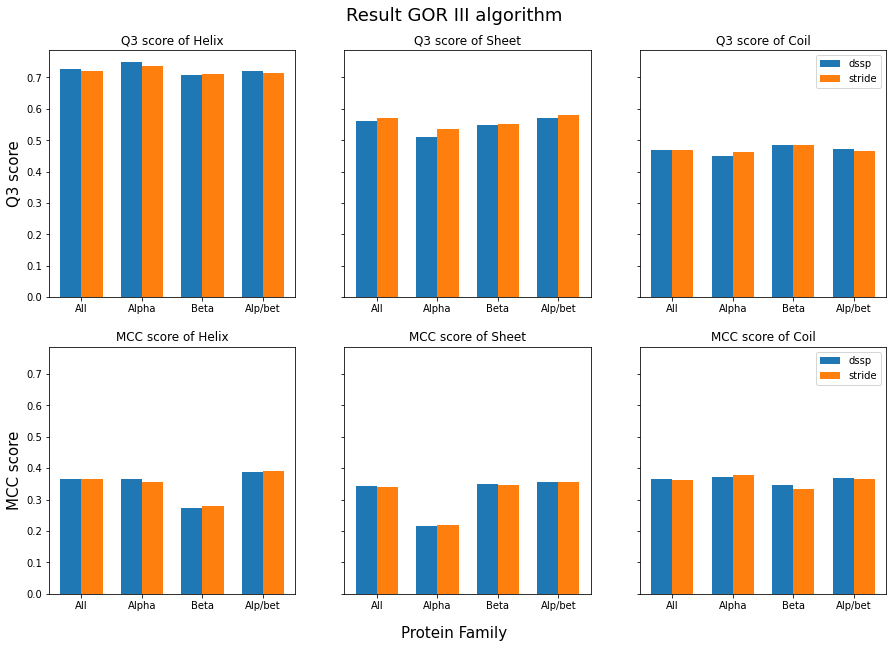

In [16]:
fig, (axesQ3, axesMCC) = plt.subplots(nrows=2, ncols=3, sharey=True , figsize=(15,10))
labels = ["All","Alpha","Beta","Alp/bet"]
locationLabels = np.arange(len(labels))
widthBars = 0.35

for i, (SS, axQ3) in enumerate(zip(("Helix","Sheet","Coil"),axesQ3)):
    if i==0:
        axQ3.set_ylabel("Q3 score",fontsize=15)
    axQ3.set_title(f"Q3 score of {SS}")
    
    axQ3.bar(locationLabels - widthBars/2, resultsQ3[:,0,i], widthBars, label="dssp")
    axQ3.bar(locationLabels + widthBars/2, resultsQ3[:,1,i], widthBars, label="stride")
    axQ3.set_xticks(locationLabels)
    axQ3.set_xticklabels(labels)
    if i==2:
        axQ3.legend()
        
for i, (SS, axMCC) in enumerate(zip(("Helix","Sheet","Coil"),axesMCC)):
    if i==0:
        axMCC.set_ylabel("MCC score",fontsize=15)
    axMCC.set_title(f"MCC score of {SS}")
    
    axMCC.bar(locationLabels - widthBars/2, resultsMCC[:,0,i], widthBars, label="dssp")
    axMCC.bar(locationLabels + widthBars/2, resultsMCC[:,1,i], widthBars, label="stride")
    axMCC.set_xticks(locationLabels)
    axMCC.set_xticklabels(labels)
    if i==2:
        axMCC.legend()
        
fig.text(0.5,0.07, "Protein Family", ha="center", va="center",fontsize=15)
fig.suptitle(f"Result GOR III algorithm", fontsize=18,x = 0.5, y = 0.94)
    

### Discussion results:

Do not forget to talk about remove the NaN values.

---

## Investigation one specific protein:

To convice that the GOR3 algorithm is indeed working. We will focus for a moment on 1 specific protein and vieuw its results of the GOR algorithm. 

1. First we will do a GOR algorithm with a frequency table that is constructed with just that protein. We then indeed see that the prediction becomes 100% correct and that the GOR algorithm works correctly.
2. We vieuw the analysis of the protein the proper way, with a full Freq table with the test protein left out. We then evaluate the mutual information level of each SS and then indeed see that the information rises (somewhat) where it needs to be. 

### 1.) GOR 3 algorithm with itself:

The protein that we will be considering the is called "1gpp". This is a challeging one since it contains 3 different skips and changes often from structure.

First we again create the dictionary database and extract the "1gpp" protein, which has a chaincode of A.

In [17]:
dsspDictionary = createDataset()
residue_1GPP, SS_1GPP = dsspDictionary["1gpp_A"]

Next we compute its specific frequency table. 

And as with the analysis where it is zero we put it equal to zero. We also now need to do this with the SS per RJ count since the protein 1gpp is not long enough to cover every SS with every residue.

In [18]:
table_1GPP, countSS_1GPP, countSSperR_1GPP = freqTableOfProtein(residue_1GPP, SS_1GPP)
table_1GPP[table_1GPP ==0 ] = 0.00001
countSSperR_1GPP[countSSperR_1GPP==0] = 0.00001

Compute the logDiff terms.

In [19]:
otherSS = np.array([[1,2],[0,2],[0,1]])
logDiff_1GPP = np.log(np.sum(countSS_1GPP[otherSS],axis=-1)/countSS_1GPP)
logDiffRj_1GPP = np.log(np.sum(countSSperR_1GPP[otherSS],axis=-2)/countSSperR_1GPP) # -2 since -1 are the amino acids     

Make the SS prediction of the protein 1gpp on its own frequency table. 

We now also store the mutual information of each SS at each residue in `ISS_1GPP`

In [21]:
SS_result_1GPP, ISS_1GPP = predictSS(residue_1GPP,table_1GPP,logDiff_1GPP,logDiffRj_1GPP)

Plot the information for each SS toghether with the true underlying SS of the 1gpp protein.

Text(0.5, 1.0, 'GorIII analysis of the protein 1gpp on itself')

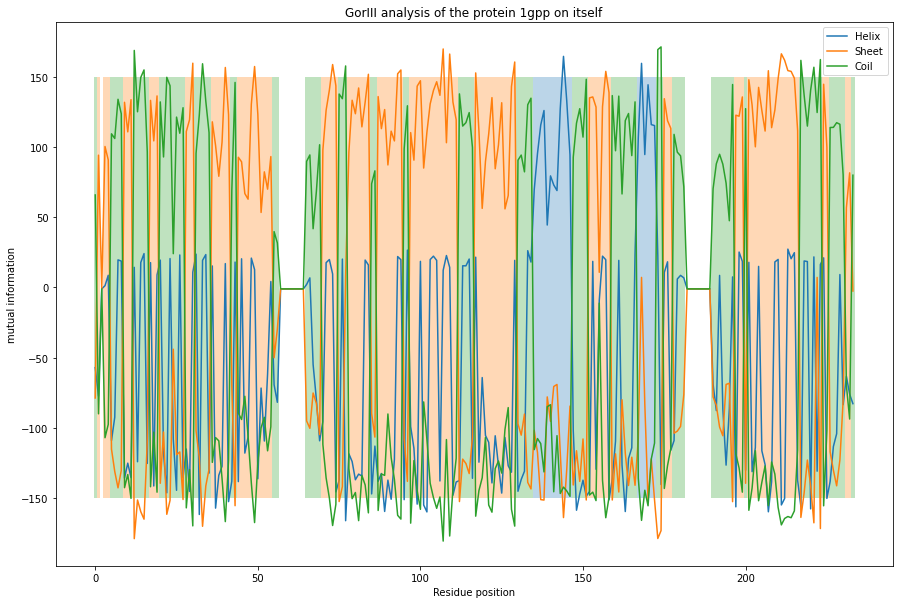

In [24]:
fig = plt.figure(figsize = (15,10))
plt.bar(np.where(SS_1GPP==0)[0],height=300,width=1,alpha=0.3,bottom=-150)
plt.bar(np.where(SS_1GPP==1)[0],height=300,width=1,alpha=0.3,bottom=-150)
plt.bar(np.where(SS_1GPP==2)[0],height=300,width=1,alpha=0.3,bottom=-150)
plt.plot(ISS_1GPP[0],label="Helix")
plt.plot(ISS_1GPP[1],label="Sheet")
plt.plot(ISS_1GPP[2],label="Coil")
plt.legend()

plt.xlabel("Residue position")
plt.ylabel("mutual information")
plt.title("Gor 3 analysis of the protein 1gpp on itself")

### Interpretation figure:

Insert interpretation

------

To verify that indeed the prediction is perfect. Compute the Q3 and MCC score

In [34]:
validEntries = SS_result_1GPP>=0
ValidSS_result_1GPP = SS_result_1GPP[validEntries]
ValidSS_1GPP = SS_1GPP[validEntries]
            
Q3 = proteinQ3(ValidSS_result_1GPP, ValidSS_1GPP)
MCC = proteinMCC(ValidSS_result_1GPP, ValidSS_1GPP)
print(f"Q3={Q3}, MCC={MCC}")

Q3=[1. 1. 1.], MCC=[1. 1. 1.]


And hence we see that the prediction per SS is perfect

### 2.) Analysis protein proper way

Now analyse the same protein 1gpp but now the properway by computing the full frequency table of the whole data set:

In [25]:
totalFreqTable = np.zeros(shape=(3,17,20,20))
totalCountSS = np.zeros(3)
totalCountSSperR = np.zeros(shape=(3,20))
    
#First compute the full freqTable
for key, (proteinSequence, trueSS) in dsspDictionary.items():
    freqTableFromProt, countSSFromProt, countSSperRFromProt = freqTableOfProtein(proteinSequence, trueSS)
    totalFreqTable += freqTableFromProt
    totalCountSS += countSSFromProt
    totalCountSSperR += countSSperRFromProt

Reload the sequence and freqTable of 1gpp since we previously changed it the zero elements to 0.00001

In [42]:
testProteinSeq, testTrueSS = dsspDictionary["1gpp_A"]
(table, count, countPerR) = freqTableOfProtein(testProteinSeq, testTrueSS)

In [43]:
subTable = totalFreqTable - table
subCount = totalCountSS - count
subCountPerR = totalCountSSperR - countPerR

subLog = np.log(np.sum(subCount[otherSS],axis=-1)/subCount)
subLogRj = np.log(np.sum(subCountPerR[otherSS],axis=-2)/subCountPerR) # -2 since -1 are the amino acids

subTable[subTable==0] = 0.00001

Predict the SS

In [44]:
SS_result, ISS = predictSS(testProteinSeq,subTable,subLog,subLogRj)

Again plot it.

Text(0.5, 1.0, 'Proper Gor 3 analysis on protein 1gpp')

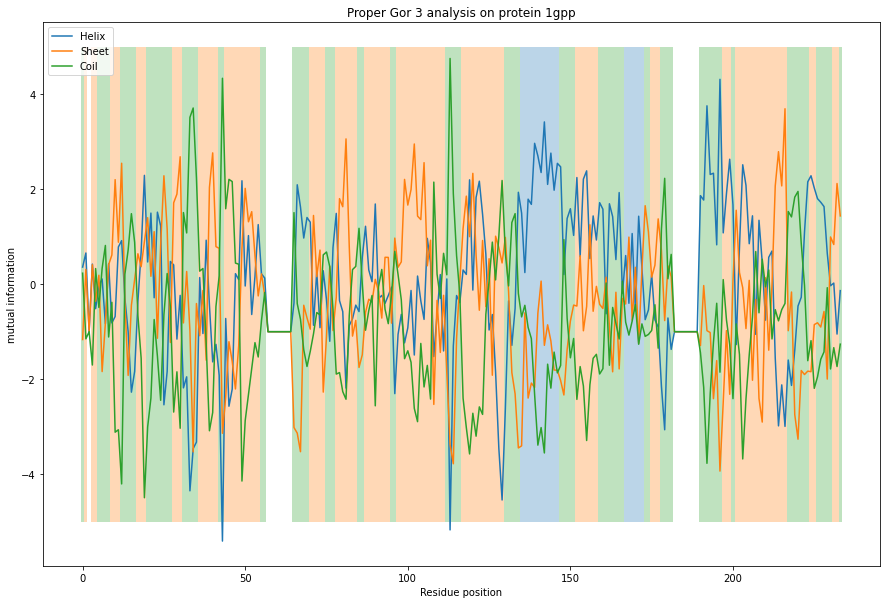

In [45]:
fig = plt.figure(figsize = (15,10))
plt.bar(np.where(testTrueSS==0)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(testTrueSS==1)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(testTrueSS==2)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.plot(ISS[0],label="Helix")
plt.plot(ISS[1],label="Sheet")
plt.plot(ISS[2],label="Coil")
plt.legend()

plt.xlabel("Residue position")
plt.ylabel("mutual information")
plt.title("Proper Gor 3 analysis on protein 1gpp")

In [39]:
validEntries = SS_result>=0
ValidSS_result = SS_result[validEntries]
ValidtestTrueSS = testTrueSS[validEntries]
            
Q3 = proteinQ3(ValidSS_result, ValidtestTrueSS)
MCC = proteinMCC(ValidSS_result, ValidtestTrueSS)
print(f"Q3={Q3}, MCC={MCC}")

Q3=[0.88888889 0.44545455 0.35955056], MCC=[0.27036806 0.2887275  0.22380015]


### Discussion:



Replace the "1gpp_A" and one can explore other proteins. This "1gpp_A" but with others it can do it a bit better. For example the protein "2gpi_A" produces much better see here under:

Q3=[0.96774194 0.58333333 0.29411765], MCC=[0.49863239 0.49713862 0.40736645]


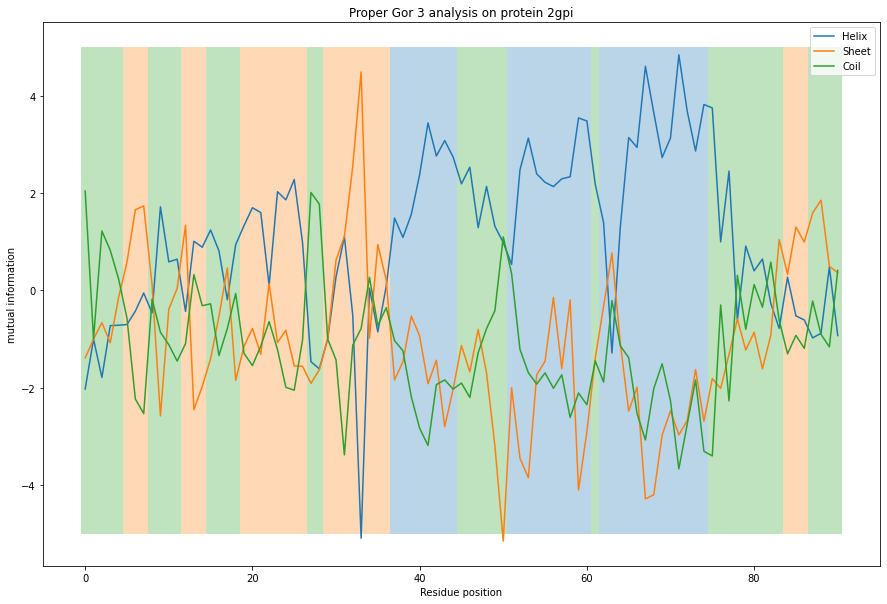

In [46]:
testProteinSeq, testTrueSS = dsspDictionary["2gpi_A"]
(table, count, countPerR) = freqTableOfProtein(testProteinSeq, testTrueSS)

subTable = totalFreqTable - table
subCount = totalCountSS - count
subCountPerR = totalCountSSperR - countPerR

subLog = np.log(np.sum(subCount[otherSS],axis=-1)/subCount)
subLogRj = np.log(np.sum(subCountPerR[otherSS],axis=-2)/subCountPerR) # -2 since -1 are the amino acids

subTable[subTable==0] = 0.00001

SS_result, ISS = predictSS(testProteinSeq,subTable,subLog,subLogRj)

fig = plt.figure(figsize = (15,10))
plt.bar(np.where(testTrueSS==0)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(testTrueSS==1)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(testTrueSS==2)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.plot(ISS[0],label="Helix")
plt.plot(ISS[1],label="Sheet")
plt.plot(ISS[2],label="Coil")
plt.legend()

plt.xlabel("Residue position")
plt.ylabel("mutual information")
plt.title("Proper Gor 3 analysis on protein 2gpi")


validEntries = SS_result>=0
ValidSS_result = SS_result[validEntries]
ValidtestTrueSS = testTrueSS[validEntries]
            
Q3 = proteinQ3(ValidSS_result, ValidtestTrueSS)
MCC = proteinMCC(ValidSS_result, ValidtestTrueSS)
print(f"Q3={Q3}, MCC={MCC}")

# Part 2: Prediction protein family

In this section we will discuss the protein family prediction based on the SS sequence.

So given is a SS sequence and we want to classify it in a protein family. For which the solution is given in the text file: `catch_info.txt`. 

For the classification I have decided to work with the python module `sci-kit learn` [Homepage](https://scikit-learn.org/stable/index.html) and do the classification via a descion tree. 

To train the tree a set of feature vectors is which is determined from the set of the SS sequences and a target vectors that contains that says to which protein family the SS sequence belongs.

### Preparing the target.

Let's first creat the target variable, which will just be an numerical vector where:

- 0 = Alpha
- 1 = Beta
- 2 = Alpha/beta

We do not consider the "None" category since it is way to small. 

We should then also remove the "None" entries from the SS sequence data set. This is being done in the following lines of code:

In [48]:
# create the data sets:
dataDssp = createDataset()
dfProtFam = pd.read_csv("inputData/cath_info.txt",sep="\t", header=None, names=["PDB_code", "PDB_chain_code","protein_family"])

In [49]:
# Remove entries of "None"
# Remove the invalid proteins from the dictionary
dfProtFam_grouped= dfProtFam.groupby(["PDB_code","PDB_chain_code"], sort=False)
for (PDB_code, Chain_code), dataFrame in dfProtFam_grouped:
    ProtFam = dataFrame["protein_family"].values[0]
    if ProtFam =="None":
        key = PDB_code+"_"+Chain_code
        del dataDssp[key]
# Remove the invalid proteins from the protFam dataframe
dfProtFam = dfProtFam[dfProtFam.protein_family != "None"]

Now that the "None" entries have been removed from both the sequence dictionary and proteinFamily datframe, we create the numerical target vector that tells to which category the SS belongs.

This is done in the code below, with some additional summary:

In [50]:
# Create a target vector that the classifier needs to assign:
classDictionary = {"Alpha":0, "Beta":1, "Alpha/beta":2}
target = pd.to_numeric( dfProtFam["protein_family"].map(classDictionary), downcast="signed").values.astype(int)
N = len(target)
_, counts = np.unique(target,return_counts=True)
print(f"Total = {N}")
print(f"Number Alpha = {counts[0]} = {np.round(counts[0]/N*100,2)}%")
print(f"Number Beta = {counts[1]} = {np.round(counts[1]/N*100,2)}%")
print(f"Number Alpha/beta = {counts[2]} = {np.round(counts[2]/N*100,2)}%")

Total = 492
Number Alpha = 132 = 26.83%
Number Beta = 100 = 20.33%
Number Alpha/beta = 260 = 52.85%


We see that there is a class imbalance present but not extremely severe

### Extracting the features

We now want to extract some specific features from a given SS sequence which we will give our Tree as input:

The following 9 features are considerd:

1. 3 Features on percentage of a SS in the sequence:
    1. percentage of Helix in SS sequence
    2. percentage of Sheet in SS sequence
    3. percentage of Coil in SS sequence
2. 3 Features on average length of a particular SS in the sequence:
    1. Average lenght of the Helix regions
    2. Average length of the Sheet regions
    3. Average length of the Coil regions
3. 3 Features on the longest length of a particular SS region in the sequence:
    1. number of residues in the longest Helix region.
    2. number of residues in the longest Sheet region.
    3. number of residues in the longest Coil region.
    
If for a particular SS sequence, some SS does not exist we then say that the region lenght =0

The function `featVect`, extracts the feature of from a given SS sequence. The function `lengthSSRegion` helps with the determination of the features. Lastly, the function `featVectFromDict` returns the sets of feature vectors from a dictionary set of SS sequences.

In [51]:
def featVect(SS):
    """ Return the feature vector from a given SS"""
    numberFeatures = 9
    featVect = -np.ones(9)
    # features is simply the percentage of each SS.
    featVect[0:3] = np.sum((SS==0,SS==1,SS==2),axis=1)/len(SS)
    # Average length of each SS. 
    lengthsRegionSS = (lengthSSRegion(SS,0),lengthSSRegion(SS,1),lengthSSRegion(SS,2))
    for i, lengthSS in enumerate(lengthsRegionSS):
        featVect[i+3] = np.mean(lengthSS)
    # the longest length of each SS.
    for i, lengthSS in enumerate(lengthsRegionSS):
        featVect[i+6] = np.max(lengthSS)
    return featVect

In [52]:
def lengthSSRegion(SSarray,SS):
    """Returns the length of the SS regions"""
    lengths = []
    isInRegion = False
    count = 0
    for ss in SSarray:
        if ss==SS:# We are still in the region or we just started with one.
            count+=1
            isInRegion=True
        elif ss!=SS and isInRegion==True:# Aka it stopped
            isInRegion= False
            lengths.append(count)
            count=0
    if isInRegion: # If the for loop ended with still a region store it
        lengths.append(count)
    if len(lengths)==0: # Return a 0 in the case the 
        lengths.append(0)
    return lengths

In [53]:
# Extract features from the SS array:
def featVectFromDict(dictionary):
    """ Returns the feature Vector from the dictionary dataset"""
    numbProteins = len(dictionary)
    for i, (protName, (seq, SS)) in enumerate(dictionary.items()):
        if i==0:
            featV = featVect(SS)
            numbFeatures = len(featV)
            featureVectors = np.zeros((numbProteins,numbFeatures))
        featureVectors[i] = featVect(SS)
    return featureVectors
featureVectors = featVectFromDict(dataDssp)

### Which dataset to use?

Now comes the question on which data set do we train our Tree? In my exploration, I first started on the true SS sequence of the proteins. The prediction results of the three were very strong ($\pm$ 84%). However, if you then feed the Tree, that was trained on true SS sequences, on SS sequences predicted by the GOR algorithm the accuracy went way down. 

So to get better results with predictions we will train the descion Tree directly on the SS sequences that where predicted by the GOR data. 

Create a new dictionary that contains the GOR prediction:

In [54]:
# Create the total frequency table.
totalFreqTable = np.zeros(shape=(3,17,20,20))
totalCountSS = np.zeros(3)
totalCountSSperR = np.zeros(shape=(3,20))
otherSS = np.array([[1,2],[0,2],[0,1]])    

proteinDictionary = createDataset(dataSet = "dssp")
    
#First compute the full freqTable
for key, (proteinSequence, trueSS) in proteinDictionary.items():
    freqTableFromProt, countSSFromProt, countSSperRFromProt = freqTableOfProtein(proteinSequence, trueSS)
    totalFreqTable += freqTableFromProt
    totalCountSS += countSSFromProt
    totalCountSSperR += countSSperRFromProt

totalLog = np.log(np.sum(totalCountSS[otherSS],axis=-1)/totalCountSS)
totalLogRj = np.log(np.sum(totalCountSSperR[otherSS],axis=-2)/totalCountSSperR)
totalFreqTable[totalFreqTable==0] = 0.00001


# Create the data set based on GOR algorihtm
dataDsspGOR = {}
for key, (protSeq, trueSS) in dataDssp.items():
    SSGor, _ = predictSS(protSeq, totalFreqTable, totalLog, totalLogRj)
    dataDsspGOR[key] = (protSeq, SSGor)

In the code above we did not predict the SS fully correctly, because the freqTable that was used to predict the SS for a test protein also contained the frequency count of that test protein.

Lastly, create the feature vector using the GOR SS data.

In [55]:
featVectGOR = featVectFromDict(dataDsspGOR)

## Prediction SS structure

In [56]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

The training and prediction will follow the methodology of the sci-kit module. What we do is first create a pipeline. This pipeline contains preprocessing of the data and the estimator (in our case the tree). 

This pipeline is then trained on trainings data and can then predict unseen data. To split the data we use the function `train_test_split` where we can tell how much percentage should be trainings data. I chose 75% trainings data.

One can also do cross validation which is also shown below with 5-folds.

In [57]:
pipe =  make_pipeline(
    preprocessing.StandardScaler(), # Z-normalise the input features according to the traings set
    DecisionTreeClassifier(
        max_depth = 5, # Let the descion tree only grow maximum 5 layers. (prevent overfitting)
        random_state=0 # Seed used by the Tree
    )
)

# Split the data in to test and train.
X_train, X_test, y_train, y_test = train_test_split(featVectGOR, target, train_size=0.75, random_state=0)

# Fit the classifier: on the train data.
pipe.fit(X_train, y_train)

# Do crossValidation 
CVresults = cross_validate(pipe, featVectGOR ,target,
                        cv= 5,
                        scoring="accuracy")

It has been chosen to limit the Tree to maximum depth of 5 (meaning only maximum 5 decesion layers). 

This is to prevent overfitting, because the fully grown tree is namely 19 layers deep and achieves 100% accuracy on the training data. However, one achieves higher test accuracy with a smaller tree.

During the exploration a maximum depth of 3 produced an even higher accuracy as that of 5. But the class accuracy for the "Beta" was significantly worse. So to balance things out 5 was eventually chosen.

### Results training.

#### Cross validation results:

In [59]:
print(f'accuracy CV = {CVresults["test_score"]}')
print(f'mean accuracy CV = {np.mean(CVresults["test_score"])}')

accuracy CV = [0.68686869 0.71717172 0.64285714 0.78571429 0.69387755]
mean accuracy CV = 0.7052978767264481


We see that we get a 70% accuracy when we predict the protein family. (Not bad)

Problem with the cross validation is that you cannot go much more in detail. With the manually split train and test set we can explore this further

#### Train test set results:

Here we explore the accuracy of the test set per protein family and vieuw the confusion matrix of the predicted test set which will give us more insight on how the protein family is predicted.

Lastly, we also vieuw the F1 score per protein family. F1 score can be a better measure then accuarcy in the case of low number of predictions and class imbalance.

In [60]:
y_predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_predicted, y_test)
cm = metrics.confusion_matrix(y_test, y_predicted)
normalisedCM = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
f1Score =metrics.f1_score(y_predicted, y_test, average=None)
print(f"accuracy = {accuracy}")
print(f"Accuracy per class = {normalisedCM.diagonal()}")
print(f"Confusion matrix = \n{cm}")
print(f"F1 Score per class = {f1Score}")

accuracy = 0.7073170731707317
Accuracy per class = [0.81578947 0.51724138 0.73214286]
Confusion matrix = 
[[31  1  6]
 [ 3 15 11]
 [ 7  8 41]]
F1 Score per class = [0.78481013 0.56603774 0.71929825]


discussion:

First, we see that the accuracy on our test set is the same as that we got from the cross validation. But next we see that there are large differences in the accuracies per class. With the helix performing really well but the sheet not so much. 

This result is best understood with the confusion matrix. Each row represents the real protein family that is being predicted, while the columns represent the protein family in which it got predicted. 

We see that 11 of true "beta" families got predicted as Alpha/Beta. This can be explained when remembering the analysis of the GOR algorithm with one protein. There we saw that the GOR algorithm quickly liked to predict helix, while the sheet did not so quickly came up. And so "Beta" family probably has only beta sheets, but the GOR algorithm quickly introduce somes alpha helix in the SS sequence -> Making it look more like "Alpha/beta" family. 

This is not the case with the "Alpha" family, because again it seems the GOR algorithm more easily assigns stuff helix then sheet. Hence the mistake that "Alpha" gets mixed with "Alpha/beta" does not happen that much. 

What is certain is that the confusion of an "Alpha" to be "Beta" or reverse does almost does not happen at all. Which is expected.

Lastly, we see that F1 score per family is very simular to that of the accuracy. 

## The important variable:

The nice thing about descion Trees is that they are not black boxes. And bases on the splitting that three has done. It is possible to asses an importance to the input features. 

Which in our case is as follows:

In [61]:
pipe.steps[1][1].feature_importances_

array([0.21933894, 0.51211807, 0.        , 0.05757946, 0.09933744,
       0.00188193, 0.02939098, 0.04120913, 0.03914406])

We see that 2 features already represent 70% of the importance in predicting the data:

- 51% importance to the feature: percentage of residues that has Sheet as SS
- 21% importance to the feature: percentage of residues that has Helix as SS

Next, it the average lenght of an Helix/Sheet region seems to be the most important. 

# Part 3. Using evolution information